<a href="https://colab.research.google.com/github/mausombi/projectseekhan/blob/main/projectseekhannotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Finetune LLMs for Free: A Step-by-Step Open-Source Tutorial**

**Welcome to this tutorial!** In the following steps, we will show you how to fine-tune the llama-2 7B LLM for **Question Answering** on your own private data. Simply run the cells sequentially, to learn how to load the model and your data, train the model, and finally ask questions about your data.

### Why would this tutorial be helpful for you?

Our tutorial to fine-tune llama 2 uniquely offers several advantages over others currently out in the internet, namely:

1. The ability to **fine-tune on freeform text articles and documents**; we don't assume you manually format your data in well defined formats like CSV, JSON, etc.

2. Offer **greater degree of control** and **in-depth explanations** to users on tuning parameters to **optimize performance of fine-tuned model** specific for your use case

3. Provide a **walkthrough of fine-tuning Llama-2 with high accuracy and demonstration** of this model based on a **realistic use case**.

#### Authors and Credits

[Sri Ranganathan Palaniappan](https://www.linkedin.com/in/sri-ranganathan-palaniappan/), CS undergrad student at Georgia Tech.

[Mansi Phute](https://www.linkedin.com/in/mansi-phute-413744166/),  CS masters student at Georgia Tech

[Seongmin Lee](https://www.linkedin.com/in/seongmin-lee-8b8a97209/),  CS PhD student at Georgia Tech

[Polo Chau](https://www.linkedin.com/in/polochau/),  Associate Professor at Georgia Tech.

**Memory requirements: How GPU(s) to use?**

This tutorial needs no more than 14GB GPU RAM. Depending on the GPU you’re using, one GPU may be sufficient (e.g., NVIDIA RTX 4090 has 24GB RAM). Modify the code below to specify the number of GPUs to use.

Refer to this ***medium post*** to learn more about the memory requirements for finetuning Llama-2-7B!

**Note: If you're using Google Colab, the code below automatically sets the GPU to T4.**

In [ ]:
!pip install GPUtil

import torch
import GPUtil
import os

GPUtil.showUtilization()

if torch.cuda.is_available():
    print("GPU is available!")
else:
    print("GPU not available.")

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

# Change if needed to accomodate memory requirements!
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Set to the GPU ID (0 for T4)

!nvidia-smi # Verify notebook is running on a GPU

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=ab8dcbfeed118fcbe8eeb81fe300751a1960ea48c34537db0eccdbe8b9865270
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil
| ID | GPU | MEM |
------------------
GPU not available.
/bin/bash: line 1: nvidia-smi: command not found


## Import Libraries

Execute the cell below to import the necessary libraries for fine-tuning Llama-2.

**Note:** *You only need to run this cell once initially, and you can then comment it out.*


In [ ]:

!pip install -q git+https://github.com/huggingface/peft.git
!pip install -q -i https://pypi.org/simple/ bitsandbytes
!pip install -q transformers==4.30
!pip install -q datasets


import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig,LlamaTokenizer
from huggingface_hub import notebook_login
from datasets import load_dataset
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model
from datetime import datetime

if 'COLAB_GPU' in os.environ:
    from google.colab import output
    output.enable_custom_widget_manager()

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 275.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the fo

## **Load and Configure Model**

**Since Llama-2 is a gated model, do the following steps to get access to the model:**

**1. Create an account in HuggingFace [here](https://huggingface.co/join)**

**2. Request access to the [Llama-2-7b-chat model here](https://huggingface.co/meta-llama/Llama-2-7b-chat-hf).**

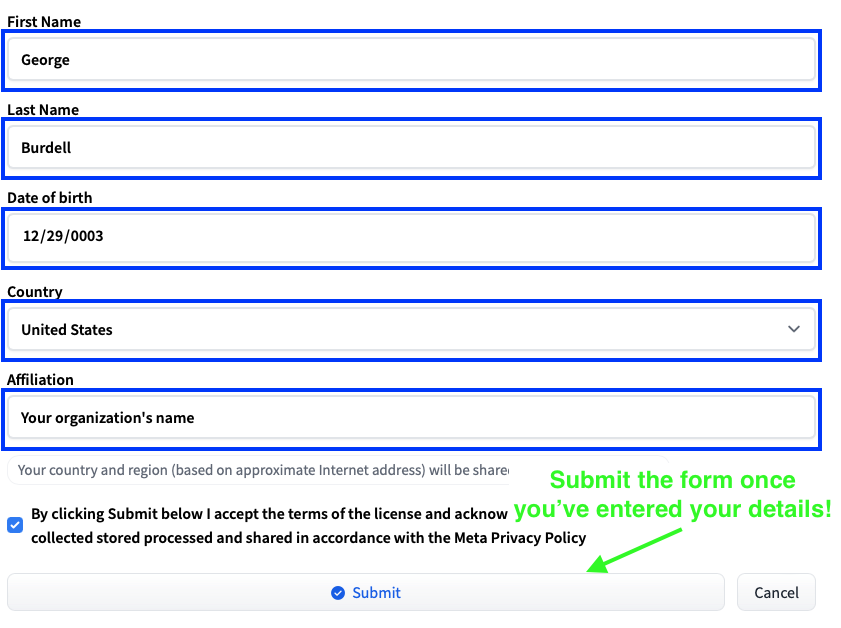

**Once you fill out the form as instructed above, you should get an email confirmation granting access to the model. You're good to proceed with the tutorial!**

We load the model from Hugging Face using **4-bit quantization** with the [`BitsAndBytesConfig`](https://huggingface.co/docs/transformers/main_classes/quantization#transformers.BitsAndBytesConfig)
 from the Hugging Face Transformers library.


In [ ]:
if 'COLAB_GPU' in os.environ:
    !huggingface-cli login
else:
    notebook_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
base_model_id = "meta-llama/Llama-2-7b-chat-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

'''
NOTE:


load_in_4bit: Enables loading the model using 4-bit quantization, reducing
memory and computational costs.

bnb_4bit_compute_dtype: Sets the computational data type for the 4-bit quantized
model, controlling precision during inference or training.
'''

model = AutoModelForCausalLM.from_pretrained(base_model_id,
                                             quantization_config=bnb_config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

RuntimeError: No GPU found. A GPU is needed for quantization.

In [ ]:
# for without GPU
base_model_id = "meta-llama/Llama-2-7b-chat-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

'''
NOTE:


load_in_4bit: Enables loading the model using 4-bit quantization, reducing
memory and computational costs.

bnb_4bit_compute_dtype: Sets the computational data type for the 4-bit quantized
model, controlling precision during inference or training.
'''

model = AutoModelForCausalLM.from_pretrained(base_model_id)

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

In [ ]:
from transformers import AutoModelForCausalLM

base_model_id = "meta-llama/Llama-2-7b-chat-hf"
try:
    model = AutoModelForCausalLM.from_pretrained(base_model_id)
    print("Model downloaded and loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Loading datasets for training

<!-- For fine-tuning Llama-2-7b-chat model on your own private data, depending on the usecases, the format of your input data plays a significant role in the training process. In this guide, we'll explore two common formats for organizing your data: **JSON for structured data and text (.txt) for unstructured data**. -->

<!-- ### **Option 1: Structured Data (JSON Format)**

JSON formatted input data provides a structured format consisting of question-answer pairs. Each datapoint (each line) consists of a question and its corresponding answer, allowing for clear and explicit mapping of question-answer pairs. This format is ideal for scenarios where data is neatly organized and follows a predictable structure.

**Pros:**
- Clear and organized structure, resulting in better training results.
- Explicit mapping for question with corresponding answer.
- Suitable for datasets with consistent formatting.

**Cons:**
- Labor intensive: requires additional processing to convert unstructured data into a structured format.
- Less flexible for datasets with varying or irregular structures. -->

<!-- ### **Loading data as multiple .txt files** -->
### **Unstructured Data (Text Format)**

**Pros:**
- Flexible with diverse data formats with irregular structures, not limited to Question-Answer pairs.
- Can contain blocks of text from guides/articles or multiple Q&A pairs.
- Simple to create and modify; offers enhanced readability and reduced labor intensity.

**Cons:**
- Compared to JSON format, offers less structured data, potentially resulting in inferior training outcomes.


All of our training data are formatted as **multiple .txt files**.


`train_dataset`: *Important for model training, this dataset contains the training data used to update the model’s weights through backpropagation.*

We have provided example training .txt files cloned from a github repository that shows how your private data may be formatted.

In [ ]:
!git clone https://github.com/poloclub/llm-tutorial-data.git

if 'COLAB_GPU' in os.environ:
    dir_path = '/content/llm-tutorial-data/'
else:
    dir_path = 'llm-tutorial-data'

os.chdir(dir_path)

train_dataset = load_dataset("text", data_files={"train":
                ["hawaii_wf_1.txt", "hawaii_wf_2.txt",
                 "hawaii_wf_3.txt","hawaii_wf_4.txt",
                 "hawaii_wf_5.txt","hawaii_wf_6.txt",
                 "hawaii_wf_7.txt","hawaii_wf_8.txt",
                "hawaii_wf_9.txt","hawaii_wf_10.txt","hawaii_wf_11.txt"]}, split='train')

os.chdir('..')

Cloning into 'llm-tutorial-data'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 0), reused 13 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 61.41 KiB | 8.77 MiB/s, done.


Generating train split: 0 examples [00:00, ? examples/s]

### **Initialize & configure tokenizer**

We have set `add_eos_token = True` so that the model knows how to recognize the “end of sentence". We have also added a special pad token `'[PAD]'` to pad shorter lines to match the length of longer ones.

In [ ]:
tokenizer = LlamaTokenizer.from_pretrained(base_model_id, use_fast=False,
                                           trust_remote_code=True,
                                           add_eos_token=True)

'''
We initialize the Llama tokenizer (slow) for the Llama-2-7b-chat model.
The Llama tokenizer is known to have issues with automatically setting
the End-of-sentence (eos) token and the padding (pad) token.
'''

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# set the pad token to indicate that it's the end-of-sentence
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

Using pad_token, but it is not set yet.


### **Tokenize Prompt for formatted data**

We tokenize—converting text into numbers to make it understandable for LLMs—our training dataset using the code below:


In [ ]:
tokenized_train_dataset=[]
for phrase in train_dataset:
    tokenized_train_dataset.append(tokenizer(phrase['text']))

### ***Bonus Option: Structured data (JSONL format)***

*You can also finetune your model on structured data which is formatted as JSONL files! Each datapoint (each line) consists of a question and its corresponding answer, allowing for clear and explicit mapping of question-answer pairs, thus leading to **better training results**.*

*Each line is a datapoint that is formatted as:*

```json
{'Question': 'Your question goes here', 'Answer': 'Your answer goes here'}
```

*However, this format is **labor intensive and only ideal for scenarios where data is exclusively Q&A pairs** neatly organized and follows a predictable structure.*

In [ ]:
########## UNCOMMENT CODE BELOW IF INPUT DATA IS JSONL FILES ##########

### Load dataset

# from datasets import load_dataset

# train_dataset = load_dataset("json", data_files={"train":
#   ["serviceNowQA_training.jsonl"]}, split="train")

# def formatInputJSONData(datapoint):
#     text = f"{datapoint['Question']}\n{datapoint['Answer']}"
#     return text

### Tokenize data

# tokenizer = LlamaTokenizer.from_pretrained(base_model_id, use_fast=False,
#    trust_remote_code=True, add_eos_token=True)

# if tokenizer.pad_token is None:
#     tokenizer.add_special_tokens({'pad_token': '[PAD]'})

### Tokenize prompt

# def tokenizePrompt(prompt):
#     currPrompt = formatInputJSONData(prompt)
#     return tokenizer(currPrompt)

# tokenized_train_dataset = train_dataset.map(tokenizePrompt)

########## UNCOMMENT CODE ABOVE IF INPUT DATA IS JSONL FILES ##########

### **PEFT Fine-Tuning**

We now prepare the model for knowledge distillation training using the **PEFT (Parameter-Efficient Fine-Tuning)** method to significantly reduce the memory and compute requirements.


In [ ]:
# gradient checkpointing to reduce memory usage for increased compute time
model.gradient_checkpointing_enable()

# compressing the base model into a smaller, more efficient model
model = prepare_model_for_kbit_training(model)

### Configure model with LoRA

The code below uses [LoRA](https://huggingface.co/docs/diffusers/en/training/lora) (a PEFT method) to reduce the number of trainable parameters. LoRA works by decomposing the large matrix of the pre-trained model into two smaller low-rank matrices in the attention layers which drastically reduces the number of parameters that need to be fine-tuned. Refer to the __[LoRA documentation](https://opendelta.readthedocs.io/en/latest/modules/deltas.html#lora)__ to learn more about the parameters and use cases.

In [ ]:
config = LoraConfig(
    # rank of the update matrices
    # Lower rank results in smaller matrices with fewer trainable params
    r=8,

    # impacts low-rank approximation aggressiveness
    # increasing value speeds up training
    lora_alpha=64,

    # modules to apply the LoRA update matrices
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "gate_proj",
        "down_proj",
        "up_proj",
        "o_proj"
    ],

    # determines LoRA bias type, influencing training dynamics
    bias="none",


    # regulates model regularization; increasing may lead to underfitting
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)

## Training the model

We're now ready to train our Llama 2 model on our new data! We'll be using the [`Transformers`](https://huggingface.co/docs/transformers/en/index) library to create a [`Trainer`](https://huggingface.co/docs/transformers/main_classes/trainer) object for training the model. The `Trainer` takes the pre-trained model, training datasets, training arguments, and data collator as input.

Training time depends on the size of the training data, number of epochs and the configuration of the GPU used. If you run the below cell using the sample dataset provided on Google Colab T4 GPU (default), then it should take around **1 hour 30 minutes to complete training** for 3 epochs of the provided sample Hawaii wildfire dataset.

In [ ]:
### TWO IMPORTANT TRAINING PARAMETERS TO CONSIDER CHANGING

train_epochs_val = 3 # CHANGE VALUE AS NEEDED HERE!
'''
train_epochs_val is the times the model will iterate over the entire training
dataset. Increasing the value may allow the model to learn more from the data,
but be cautious of overfitting.
'''

learning_rate_val = 1e-4 # CHANGE VALUE AS NEEDED HERE!
'''
A higher learning_rate_val can lead to faster convergence, but it might
overshoot the optimal solution. Conversely, a lower value may result
in slower training but better fine-tuning.
'''


trainer = transformers.Trainer(
    model=model,                             # llama-2-7b-chat model
    train_dataset=tokenized_train_dataset,   # training data that's tokenized
    args=transformers.TrainingArguments(
        output_dir="./finetunedModel",       # directory where checkpoints are saved
        per_device_train_batch_size=2,       # number of samples processed in one forward/backward pass per GPU
        gradient_accumulation_steps=2,       # [default = 1] number of updates steps to accumulate the gradients for
        num_train_epochs=train_epochs_val,   # [IMPORTANT] number of times of complete pass through the entire training dataset
        learning_rate=learning_rate_val,     # [IMPORTANT] smaller LR for better finetuning
        bf16=False,                          # train parameters with this precision
        optim="paged_adamw_8bit",            # use paging to improve memory management of default adamw optimizer
        logging_dir="./logs",                # directory to save training log outputs
        save_strategy="epoch",               # [default = "steps"] store after every iteration of a datapoint
        save_steps=50,                       # save checkpoint after number of iterations
        logging_steps = 10                   # specify frequency of printing training loss data
    ),

    # use to form a batch from a list of elements of train_dataset
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

# if use_cache is True, past key values are used to speed up decoding
# if applicable to model. This defeats the purpose of finetuning
model.config.use_cache = False

# train the model based on the above config
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss
10,3.962300
20,3.456800
30,3.009000
40,2.866900
50,3.176900
60,2.663300
70,3.045600
80,3.064300
90,2.587400
100,2.961400


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, to

## **Load Finetuned Model**

Congratulations! You've successfully finetuned the Llama 2 model on your data. Now, let's load the finetuned model using the `BitsAndBytesConfig` we used previously.

Ensure to choose the model checkpoint with the least training loss (as seen in the training output table above).


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig,LlamaTokenizer
from peft import PeftModel

base_model_id = "meta-llama/Llama-2-7b-chat-hf"

nf4Config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = LlamaTokenizer.from_pretrained(base_model_id, use_fast=False,
                                           trust_remote_code=True,
                                           add_eos_token=True)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  #same as before
    quantization_config=nf4Config,  #same quantization config as before
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=True
)

tokenizer = LlamaTokenizer.from_pretrained(base_model_id, use_fast=False,
                                           trust_remote_code=True)

# Change model checkpoint that has least training loss in the code below
# beware of overfitting!
modelFinetuned = PeftModel.from_pretrained(base_model,"finetunedModel/checkpoint-1455")

### **Ask questions to your finetuned model!**

#### Option 1: Chatbot with Predefined Prompts

Enter your question as a string and assign it to the variable `question`.

*Note: Feel free to duplicate the below cell for new questions to keep a history of the chat.*

In [ ]:
### ENTER YOUR QUESTION BELOW

question = "Just answer this question: Tell me about the role of Maui Emergency Management Agency (MEMA) in the 2023 wildfires??"

# Format the question
eval_prompt = f"{question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

#### Option 2: Interactive chatbot!

Enter your question in the textbox that pops up after running the cell below!

*Note: Feel free to duplicate the below cell for new questions to keep a history of the chat.*

In [ ]:
### RUN THIS CELL AND ENTER YOUR QUESTION IN THE POP-UP BOX

# User enters question below
user_question = input("Enter your question: ")

# Format the question
eval_prompt = f"Just answer this question concisely: {user_question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

In [ ]:
# User enters question below
user_question = "Summarize the officer accounts of the wildfire in Hawaii?"

# Format the question
eval_prompt = f"Just answer this question accurately: {user_question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

In [ ]:
# User enters question below
user_question = "Tell me about the media coverage of the hawaii wildfires?"

# Format the question
eval_prompt = f"Just answer this question in less than 300 words: {user_question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

In [ ]:
# User enters question below
user_question = "Where were the media briefings held?"

# Format the question
eval_prompt = f"Just answer this question concisely: {user_question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

In [ ]:
# User enters question below
user_question = "Tell me about Morgue Identification and Notification Task Force (M.I.N.T)?"

# Format the question
eval_prompt = f"Question: {user_question}. Just answer this question accurately and concisely\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

In [ ]:
# User enters question below
user_question = "When did the Hawaii wildfires take place?"

# Format the question
eval_prompt = f"Question: {user_question}. Just answer this question accurately and concisely\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

In [ ]:
# User enters question below
user_question = "Which geographic areas were affected by the wildfires in Hawaii in 2023? Give me some insights on this please?"

# Format the question
eval_prompt = f"Just answer this question concisely and accurately: {user_question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

In [ ]:
torch.cuda.empty_cache()